In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix, classification_report

### Find adopted users

In [30]:
# load datasets
df_eng = pd.read_csv('takehome_user_engagement.csv', encoding='utf-8')
df_eng.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
# clean data
df_eng = df_eng.drop_duplicates()
df_eng['time_stamp'] = pd.to_datetime(df_eng['time_stamp'])

# Find adopted users
adopted_user = []

for id in df_eng.user_id.unique():
    data = df_eng[df_eng.user_id==id]
    n = len(data)
    if n>2:
        for i in range(n-2):
            if (data.time_stamp.iloc[i+2] - data.time_stamp.iloc[i]).days < 8:
                adopted_user.append(id)
                break
                
print('Number of adopted users: {}'.format(len(adopted_user)))

Number of adopted users: 1656


### Data Wrangling

In [8]:
# load dataset
df_user = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
# remove name and email columns (not useful)
df_user = df_user.drop(columns=['name', 'email'])

# convert columns to datetime object
df_user['creation_time'] = pd.to_datetime(df_user['creation_time'])
df_user['last_session_creation_time'] = pd.to_datetime(df_user['last_session_creation_time'], unit='s')

df_user.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [10]:
# there are too many categories in this column (417) - each category only has a few users

df_user.org_id.value_counts()

0      319
1      233
2      201
3      168
4      159
      ... 
396      9
400      8
397      8
386      7
416      2
Name: org_id, Length: 417, dtype: int64

In [11]:
# there are too many categories in this column (2564) - each category only has a few users

df_user.invited_by_user_id.value_counts()

10741.0    13
2527.0     12
2308.0     11
1525.0     11
11770.0    11
           ..
2746.0      1
10456.0     1
8371.0      1
6266.0      1
3572.0      1
Name: invited_by_user_id, Length: 2564, dtype: int64

In [12]:
# delete org_id and invited_by_user_id columns

df_user = df_user.drop(columns=['org_id', 'invited_by_user_id'])

In [13]:
df_user

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0
...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,ORG_INVITE,2013-09-06 06:14:15,0,0
11996,11997,2013-01-10 18:28:37,SIGNUP_GOOGLE_AUTH,2013-01-15 18:28:37,0,0
11997,11998,2014-04-27 12:45:16,GUEST_INVITE,2014-04-27 12:45:16,1,1
11998,11999,2012-05-31 11:55:59,PERSONAL_PROJECTS,2012-06-02 11:55:59,0,0


In [14]:
# Assume 2014-06-06 was the date of data getting extracted

current_day = df_user.last_session_creation_time.max()
current_day

Timestamp('2014-06-06 14:58:50')

In [18]:
# Create column for age of account
df_user['age'] = (current_day - df_user.creation_time).dt.days

#Create column for days from last login
df_user['last_seen'] = (current_day - df_user['last_session_creation_time']).dt.days

In [26]:
# Add column for adopted users
df_user['adopted'] = 0
df_user.loc[df_user.object_id.isin(adopted_user), 'adopted'] = 1

In [29]:
df_user.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,age,last_seen,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,45,45.0,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,203,67.0,1
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,443,443.0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,381,380.0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,505,500.0,0


### EDA

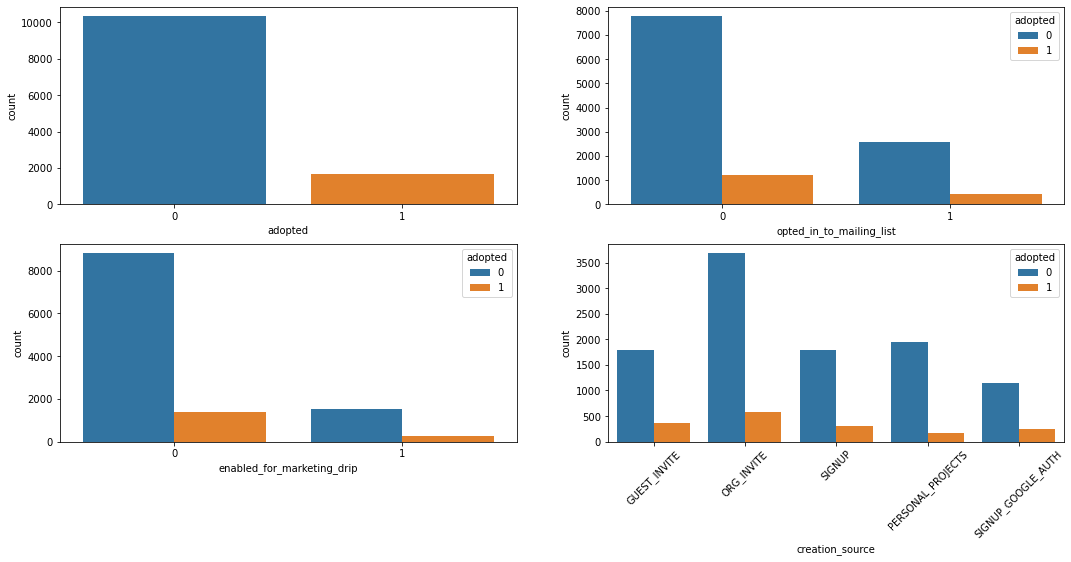

In [43]:
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='adopted', data=df_user)

plt.subplot(2, 2, 2)
sns.countplot(x='opted_in_to_mailing_list', hue='adopted', data=df_user)

plt.subplot(2, 2, 3)
sns.countplot(x='enabled_for_marketing_drip', hue='adopted', data=df_user)

plt.subplot(2, 2, 4)
sns.countplot(x='creation_source', hue='adopted', data=df_user)
plt.xticks(rotation=45);

In [55]:
# there is no significant difference in 'opted_in_to_mailing_list' between two type of users

pd.crosstab(df_user.opted_in_to_mailing_list, df_user.adopted, normalize='columns')

adopted,0,1
opted_in_to_mailing_list,,
0,0.75203,0.740942
1,0.24797,0.259058


In [57]:
# there is no significant difference in 'enabled_for_marketing_drip' between two type of users

pd.crosstab(df_user.enabled_for_marketing_drip, df_user.adopted, normalize='columns')

adopted,0,1
enabled_for_marketing_drip,,
0,0.851605,0.844807
1,0.148395,0.155193


In [61]:
# It seems like 'Personal_Projects' users are less likely to be adopted.

pd.crosstab(df_user.creation_source, df_user.adopted, normalize='columns')

adopted,0,1
creation_source,,
GUEST_INVITE,0.173434,0.222826
ORG_INVITE,0.355762,0.346618
PERSONAL_PROJECTS,0.187452,0.103865
SIGNUP,0.172564,0.182367
SIGNUP_GOOGLE_AUTH,0.110789,0.144324


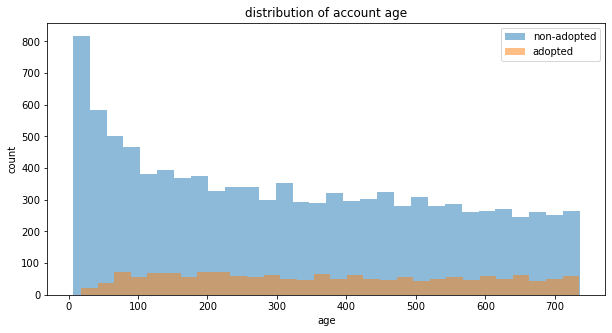

In [85]:
# Users created less than 50 days are less likely to be adopted

plt.figure(figsize=(10, 5))
plt.hist(df_user[df_user.adopted==0]['age'], bins=30, alpha=0.5, label='non-adopted')
plt.hist(df_user[df_user.adopted==1]['age'], bins=30, alpha=0.5, label='adopted')
plt.xlabel('age')
plt.ylabel('count')
plt.title('distribution of account age')
plt.legend();

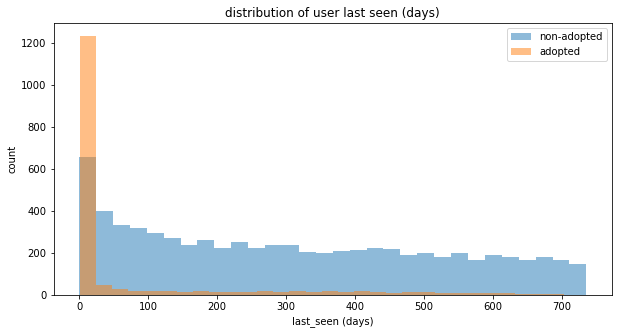

In [87]:
# most adopted users have logined recently

plt.figure(figsize=(10, 5))
plt.hist(df_user[df_user.adopted==0]['last_seen'], bins=30, alpha=0.5, label='non-adopted')
plt.hist(df_user[df_user.adopted==1]['last_seen'], bins=30, alpha=0.5, label='adopted')
plt.xlabel('last_seen (days)')
plt.ylabel('count')
plt.title('distribution of user last seen (days)')
plt.legend();

### Predictive model

In [89]:
# check missing values
df_user.isnull().sum()

object_id                        0
creation_time                    0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
age                              0
last_seen                     3177
adopted                          0
dtype: int64

In [91]:
# fill with median values

df_user.last_seen.fillna(df_user.last_seen.median(), inplace=True)

In [93]:
# One Hot Encoding for categorical feature

df_user = pd.get_dummies(df_user, columns = ['creation_source'])

In [98]:
# Create features and target

X = df_user.drop(columns=['object_id', 'creation_time', 'last_session_creation_time', 'adopted'])
y = df_user['adopted']

In [101]:
# Create train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=48)

In [102]:
# Random Forest model with default parameter

rf_clf = RandomForestClassifier(random_state=48)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print('Accuracy:', rf_clf.score(X_test, y_test))

cv_scores = cross_val_score(rf_clf, X_train, y_train, cv=5, scoring='accuracy')
print('cv_scores: {}'.format(cv_scores))

Accuracy: 0.9680555555555556
cv_scores: [0.9547619  0.9625     0.96607143 0.96607143 0.96904762]


In [103]:
# Initiate Random Forest Classifier
rf = RandomForestClassifier(max_features='auto', n_jobs=-1, random_state=19)

# Number of trees in random forest
n_estimators = [int(i) for i in np.linspace(100, 1000, 5)]

# Maximum depth of each tree
max_depth = [int(i) for i in np.linspace(10, 100, 10)]

# Create the param grid
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Apply GridSearchCV
rf_grid = RandomizedSearchCV(rf, param_grid, cv=5, n_jobs=-1, random_state=19)
rf_grid.fit(X_train, y_train)
              
print(rf_grid.best_params_) 
print('Accuracy:', rf_grid.best_score_)

cv_scores = cross_val_score(rf_grid.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')
print('cv_scores: {}'.format(cv_scores))

{'n_estimators': 1000, 'max_depth': 50}
Accuracy: 0.9639285714285715
cv_scores: [0.95535714 0.96309524 0.96666667 0.96488095 0.96964286]


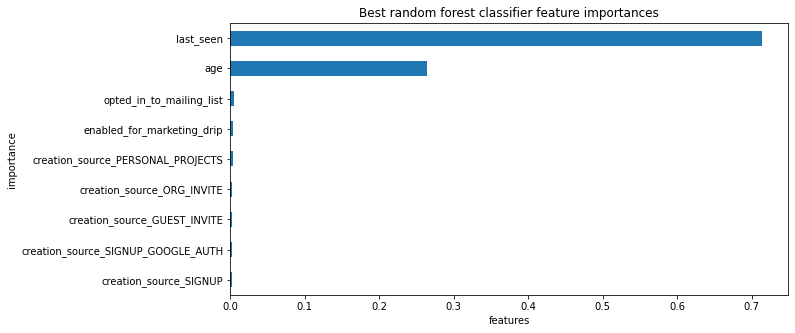

In [104]:
# Plot most important features to predict active users

plt.figure(figsize=(10, 5))
imps = rf_grid.best_estimator_.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values()
rf_feat_imps.plot(kind='barh')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest classifier feature importances');

The Random Forest Classifier Model performed 96% accuracy on the test data. <br>
It is very clear that the most important factors to predict an active user is the last login history and age of the account. <br>
The company should focus on encouraging users to login to the program more often. <br>
Age of the account is also important, but there is nothing we can do to it. 